<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# News Article Classification


Today, you are a machine learning engineer at [Upday](https://www.upday.com/home), a news app. The engine behind the app processes almost 100k news articles every day in many languages and context. In order to connect people with the right content, we need to know what the articles are about. 

The job here is to build a classifier that identify the category of an article accurately that will be fed into the recommendation algorithms of the app for better personalized content for the readers. 

You will first train a Transformer from scratch; then fine-tune a pre-trained Transformer model for text classification using 🤗; and compare performances using the same test data set.

## Learning objectives


By the end of this session, you will be able to:
- Understand how Transformer models work
- Build a Transformer model for text classification from scratch
- Fine-tune a pre-trained Transformer model for text classification using 🤗 

# Task 1. Prepare the data

1. [20 news groups data](http://qwone.com/~jason/20Newsgroups/) is one of the standard datasets in the `scikit-learn`. The 20 newsgroups dataset comprises around 18k newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the two datasets is based upon messages posted before and after a specific date.

    Take a read on its [usage](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset) and load the training and testing datasets into `train` and `test` respectively via `fetch_20newsgroups`.

In [1]:
NUM_LABELS = 20

In [2]:
from sklearn.datasets import fetch_20newsgroups

train =  fetch_20newsgroups(subset='train')  # YOUR CODE HERE
test =   fetch_20newsgroups(subset='test') # YOUR CODE HERE

In [3]:
train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [4]:
type(train) ,  type(test)

(sklearn.utils.Bunch, sklearn.utils.Bunch)

In [5]:

type(train["data"]), type(train["data"][0]), train["data"][0], type(train["target_names"][0]), train["target_names"][0]

(list,
 str,
 "From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 str,
 'alt.atheism')

1. Explore the data. For example, what is the data type of `train` and `test`? What is the data type of `train['data']`? What is in `train['target_names']`? 

    YOUR ANSWER HERE
    Train and Test are dict like types of containers of data that let you access the outpus of functions or methods by their keys.
    train['data'] is a list of strings, train['target_names'] is a list of strings where each string has the name of the category to which the correstponding text in 'data' belongs.

1. Train / validation / test splits. 

    There are four keys in each data set and we need "data" (the text) and "target" (the category). Extract the "data" and create a `pd.Series` named `X`; and extract the "target" and create a `pd.Series` named `y`. Do the same for the `test` data set, named `X_test` and `y_test`, respectively.

In [6]:
import pandas as pd



X, y = pd.Series(train["data"]) , pd.Series(train["target"]) # YOUR CODE HERE
X_test, y_test = pd.Series(test["data"]) , pd.Series(test["target"])# YOUR CODE HERE

Now split `X` and `y` into training and validation sets. Use `train_test_split` from `sklearn.model_selection` to split the data; save 10% of the data for validation and set the random state to 19.

In [7]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.1, random_state= 19) # YOUR CODE HERE

In [8]:
assert y_train.shape == (10182,)
assert y_valid.shape == (1132,)
assert y_test.shape == (7532,)

1. Convert categorical labels into dummy variables. 

    Use `pd.get_dummies` to convert labels into dummy variables for `y_train`, `y_valid`, `y_test`.

In [9]:
y_train = pd.get_dummies(y_train)   # YOUR CODE HERE
y_valid = pd.get_dummies(y_valid) # YOUR CODE HERE
y_test = pd.get_dummies(y_test) # YOUR CODE HERE

In [10]:
assert y_train.shape == (10182, NUM_LABELS)
assert y_valid.shape == (1132, NUM_LABELS)
assert y_test.shape == (7532, NUM_LABELS)


# Task 2. Attention is all you need

Recently most of the natural language processing tasks are being dominated by the `Transformer` architecture, introduced in [Attention Is All You Need](https://arxiv.org/abs/1706.03762), which used a simple mechanism called `Neural Attention` as one of its building blocks. As the title suggests this architecture didn't require any recurrent layer. We now build a text classification using Attention and Positional Embeddings.

1. Transformer (attention) Block. 

    The concept of `Neural Attention` is fairly simple; i.e., not all input information seen by a model is equally important to the task at hand. Although this concept has been utilized at various different places as well, e.g., max pooling in ConvNets, but the kind of attention we are looking for should be `context aware`.

    The attention mechanism allows output to focus attention on input while producing output while the self-attention model allows inputs to interact with each other; in other words, calculate attention of all other inputs with respect to one input.

    In the paper, the authors proposed another type of attention mechanism called multi-headed attention which refers to the fact that the outer space of the self attention layer gets factored into a set of independent sub-spaces learned separately, where each subspace is called a "head". **You need to implement the multi-head attention layer**, supplying values for two parameters: `num_heads` and `key_dim`.

    There is a learnable dense projection present after the multi-head attention which enables the layer to actually learn something, as opposed to being a purely stateless transformation. **You need to implement `dense_proj`**, use the `tf.keras.Sequential` to stack two dense layers: 
    
        1. first dense layer with `dense_dim` units and activation function `relu`;
        2. second dense layer with `embed_dim` units and no activation function.

In [11]:

from tensorflow.keras import layers as L
import tensorflow as tf
from tensorflow import keras

class TransformerBlock(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention =  L.MultiHeadAttention(num_heads= num_heads, key_dim= embed_dim) # YOUR CODE HERE
        self.dense_proj =  keras.Sequential([L.Dense(dense_dim, activation= "relu"), L.Dense(embed_dim)])  # YOUR CODE HERE
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
        super().__init__(**kwargs)
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config

1. Positional embedding. 

    The idea behind Positional Encoding is fairly simple as well: to give the model access to token order information, therefore we are going to add the token's position in the sentence to each word embedding.

    Thus, one input word embedding will have two components: the usual token vector representing the token independent of any specific context, and a position vector representing the position of the token in the current sequence.

In [12]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        self.token_embeddings =   L.Embedding(input_dim, output_dim) # YOUR CODE HERE
        self.position_embeddings =  L.Embedding(sequence_length, output_dim)  # YOUR CODE HERE or use PositionEmbedding(sequence_length=10)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        super().__init__(**kwargs)
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

1. Define some constants to parameterize the model.

In [13]:
VOCAB_SIZE = 10_000
EMBED_DIM = 256
DENSE_DIM = 32
NUM_HEADS = 2
MAX_LEN = 256

1. Tokenizer. 
    
    The tokenizer is a simple tool to convert a text into a sequence of tokens. It is used to convert the training data into a sequence of integers, which are then used as input to the model. 

    Use `Tokenizer` to create a tokenizer for the training data. Set the `num_words` parameter to the number of words to keep in the vocabulary, and `oov_token` to be `"<unk>"`.

In [14]:
from keras.preprocessing.text import Tokenizer
tokenizer =  Tokenizer(num_words= VOCAB_SIZE, oov_token= "<unk>")  # YOUR CODE HERE
tokenizer.fit_on_texts(X_train)

1. Pad the sequences. 
    
    The tokenizer outputs a sequence of integers, which are then used as input to the model. However, the model expects a sequence of fixed length. To pad the sequences to the same length, use `sequence.pad_sequences` from `keras.preprocessing`.

    Complete function `preprocess` below to 1) tokenize the texts 2) pad the sequences to the same length.

In [15]:
from keras.preprocessing import sequence
import keras.utils as util

def preprocess(texts, tokenizer, maxlen:int = MAX_LEN):
    seqs =  tokenizer.texts_to_sequences(texts) # YOUR CODE HERE
    tokenized_text = util.pad_sequences(seqs, maxlen= MAX_LEN) # YOUR CODE HERE
    return tokenized_text

1. Preprocess the data. 
    
    Use `preprocess` to preprocess the training, validation, and test data.

In [16]:
X_train = preprocess(X_train, tokenizer) # YOUR CODE HERE
X_valid = preprocess(X_valid, tokenizer) # YOUR CODE HERE
X_test  = preprocess(X_test, tokenizer) # YOUR CODE HERE

1. Define the model with the following architecture: 

    * Input Layer
    * Positional Embeddings
    * Transformer Block
    * Pooling
    * Dropout
    * Output Layer

    If you are not familiar with keras functional API, take a read [here](https://keras.io/guides/functional_api/).

In [17]:
inputs = keras.Input(shape=(None, ), dtype="int64")
x = PositionalEmbedding(MAX_LEN, VOCAB_SIZE, EMBED_DIM)(inputs)   # YOUR CODE HERE
x = TransformerBlock(EMBED_DIM , DENSE_DIM, NUM_HEADS)(x)   # YOUR CODE HERE
x = L.GlobalMaxPooling1D()(x)
x = L.Dropout(0.5)(x)
outputs = L.Dense(20, activation='softmax')(x)

model = keras.Model(inputs, outputs)

1. Compile model. 

    Use 'adam' for the optimizer and accuracy for metrics, supply the correct value for loss. 

In [18]:
model.compile(
    optimizer= "adam",                    # YOUR CODE HERE
    loss= "categorical_crossentropy" ,    # YOUR CODE HERE
    metrics= ["accuracy"]                 # YOUR CODE HERE
)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        2625536   
 ionalEmbedding)                                                 
                                                                 
 transformer_block (Transfor  (None, None, 256)        543776    
 merBlock)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

1. Add [EarlyStopping](https://keras.io/api/callbacks/early_stopping/) and [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) to stop training if the model does not improve a set metric after a given number of epochs. 

    Create an `EarlyStopping` object named `es` to stop training if the validation loss does not improve after 5 epochs. Set verbose to display messages when the callback takes an action and set `restore_best_weights` to restore model weights from the epoch with the best value of the monitored metric.
    
    Use `ReduceLROnPlateau` to reduce the learning rate if the validation loss does not improve after 3 epochs. Set verbose to display messages when the callback takes an action and use default values for other parameters.
    

In [20]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)                                                # YOUR CODE HERE
rlp =  tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)                                                  # YOUR CODE HERE

1. Train the model. 
    
    Supply both `EarlyStopping` and `ReduceLROnPlateau` for `callbacks`. Set `epochs` to 100.

In [21]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_valid, y_valid),
    callbacks=  [es, rlp] ,                        # YOUR CODE HERE
    epochs=100
)

Epoch 1/100
319/319 [==============================] - 13s 24ms/step - loss: 3.1023 - accuracy: 0.1913 - val_loss: 1.2654 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 2/100
319/319 [==============================] - 7s 22ms/step - loss: 1.0314 - accuracy: 0.7015 - val_loss: 0.6544 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 3/100
319/319 [==============================] - 7s 22ms/step - loss: 0.4478 - accuracy: 0.8616 - val_loss: 0.5322 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 4/100
319/319 [==============================] - 7s 22ms/step - loss: 0.1881 - accuracy: 0.9427 - val_loss: 0.5239 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 5/100
319/319 [==============================] - 7s 23ms/step - loss: 0.0758 - accuracy: 0.9781 - val_loss: 0.5378 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 6/100
319/319 [==============================] - 7s 23ms/step - loss: 0.0342 - accuracy: 0.9904 - val_loss: 0.6002 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 7/100
319/319 [==============================] - ET

1. Evaluate the trained model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy will be around 0.77).

In [22]:
model.evaluate(
    x= X_test,
    y= y_test,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False
)                                     # YOUR CODE HERE

236/236 [==============================] - 2s 10ms/step - loss: 0.9574 - accuracy: 0.7707


[0.9573996663093567, 0.7707116007804871]

1. Visualize both loss and accuracy curves for the training and validation data. 

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [24]:
import matplotlib.pyplot as plt

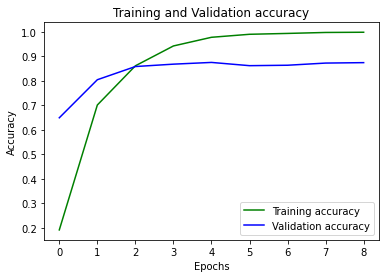

In [25]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,9)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
 
 
 
     # YOUR CODE HERE

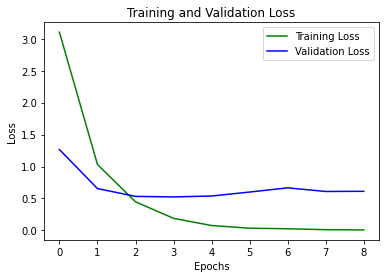

In [26]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#epochs = range(0,9)
plt.plot(epochs, loss_train, 'g', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Task 3. Fine-tune pre-trained model via 🤗

Substantial gains can be achieved by pre-training on a large corpus of text followed by fine-tuning a specific task. In this task, we will take advantage of [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/pdf/1910.01108.pdf), [`distillbert-uncased`](https://huggingface.co/distilbert-base-uncased) specifically, and fine-tune it on the 20 Newsgroups dataset.

1. Install [`Transformers`](https://huggingface.co/docs/transformers) and [`datasets`](https://huggingface.co/docs/datasets/index).

In [27]:
! pip install -U -q transformers datasets

     |████████████████████████████████| 5.3 MB 31.3 MB/s 
     |████████████████████████████████| 441 kB 57.5 MB/s 
     |████████████████████████████████| 163 kB 68.8 MB/s 
     |████████████████████████████████| 7.6 MB 57.5 MB/s 
     |████████████████████████████████| 212 kB 70.4 MB/s 
     |████████████████████████████████| 115 kB 72.0 MB/s 
     |████████████████████████████████| 127 kB 72.5 MB/s 
     |████████████████████████████████| 115 kB 74.1 MB/s 


1. Import the library and check its version.


In [28]:
import transformers
print(transformers.__version__)

4.23.1


1. Create `Dataset` objects for train / validation / test sets that are better compatible with the `Transformers` API.

    You can first create a `pd.DataFrame` with two fields: `text` and `label` with `data` and `target` from `train`. Then, call the `Dataset.from_pandas()` method to create a `Dataset` object and save it to `train_ds`. 

    Do the same for test set. 

In [29]:
from datasets import Dataset
train_ds = Dataset.from_pandas(pd.DataFrame({"text" : train["data"], "label" : train["target"]}))      # YOUR CODE HERE
test_ds  = Dataset.from_pandas( pd.DataFrame({"text" : test["data"], "label" : test["target"]}))      # YOUR CODE HERE

In [30]:
train_ds["label"][1]

4

1. Cast column `label` as `datasets.features.ClassLabel` object using [`class_encode_column`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.class_encode_column) for both `train_ds` and `test_ds`.

In [31]:
train_ds = train_ds.class_encode_column("label") # YOUR CODE HERE
test_ds = test_ds.class_encode_column("label") # YOUR CODE HERE

Stringifying the column:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9'], id=None)}

1. Create the validation set by apply [`train_ds.train_test_split()`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.train_test_split). Similarly, set the test size to 0.1, and set the random state to 19. Make sure the split is stratified by column `label`. Save the result to `train_dsd` as the result is a DatasetDict object.

    Here's another way to do train / validation / test split: [ref](https://discuss.huggingface.co/t/how-to-split-main-dataset-into-train-dev-test-as-datasetdict/1090/2)

In [33]:
train_dsd = train_ds.train_test_split(test_size=0.1, stratify_by_column="label" , seed= 19)  # YOUR CODE HERE

In [34]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Yet the 'test' set inside `train_dsd` is meant for validation, the following code will rename the test set to validation and add a new DataSet object for the test set.

In [35]:
train_dsd['validation'] = train_dsd['test']
train_dsd['test'] = test_ds

In [36]:
train_dsd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1132
    })
})

1. Load the DistilBERT tokenizer to process the text. 
    
    Use [`AutoTokenizer`](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.AutoTokenizer) to load the tokenizer for the given `model_checkpoint`. 

In [37]:
from transformers import AutoTokenizer
model_checkpoint = "distilbert-base-uncased"
tokenizer =  AutoTokenizer.from_pretrained(model_checkpoint)  # YOUR CODE HERE

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

1. Create a preprocessing function to tokenize text, truncate and pad sequences to be no longer than DistilBERT’s maximum input length:

In [38]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=MAX_LEN)

1. Use 🤗 Datasets [map](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.map) function to apply the preprocessing function over the entire dataset. You can speed up the map function by setting `batched=True` to process multiple elements of the dataset at once:

In [39]:
tokenized_text =  train_dsd.map(preprocess_function , batched = True)  # YOUR CODE HERE. not sure why i got the red bars and no 100% completion

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [40]:
tokenized_text

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1132
    })
})

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10182
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7532
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1132
    })
})

In [41]:
tokenized_text["train"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 10182
})

In [42]:
tokenized_text["train"]["text"][1]

'From: callison@uokmax.ecn.uoknor.edu (James P. Callison)\nSubject: Re: Spark Plug question?\nDistribution: na\nNntp-Posting-Host: uokmax.ecn.uoknor.edu\nOrganization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA\nLines: 21\n\nIn article <mgolden.733994052@cwis> mgolden@cwis.unomaha.edu (Brian Golden) writes:\n>  The nice thing about REAL platinum plugs is that you don\'t have to change\n>them very often at all.  (I think like 50,000 miles!!)  They might cost $10\n>each, but they would save for themselves in the long run.\n\nMy T-Bird SC\'s manual says to replace the platinum plugs every 60,000mi.\nWal-Mart has Autolite platinum plugs for $2.00 each. Are these "real"\nplatinum plugs? (I had Bosch platinums in my \'80 Fiesta and my dad\nhad \'em in his \'84 Bronco--note the keyword "had." They didn\'t last\nvery long (much less than 50,000mi) before they had to be replaced.\nI agree that they weren\'t the greatest.)\n\n\t\t\t\tJames\n\nJames P. Callison    Micro

In [43]:
tokenized_text["train"]["attention_mask"][1][:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [44]:
tokenized_text["train"]["input_ids"][1][:20]

[101,
 2013,
 1024,
 2655,
 10929,
 1030,
 1057,
 6559,
 17848,
 1012,
 14925,
 2078,
 1012,
 1057,
 6559,
 12131,
 1012,
 3968,
 2226,
 1006]

In [45]:
tokenized_text["train"]["label"][1]

17

1. Use [DataCollatorWithPadding](https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/data_collator#transformers.DataCollatorWithPadding) to create a batch of examples. Set the type of Tensor to return as 'tf' as we will fine-tune the model in TensorFlow.

In [46]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer, return_tensors= "tf")   # YOUR CODE HERE

1. To fine-tune a model in TensorFlow, start by converting datasets to the `tf.data.Dataset` format with `to_tf_dataset`. 

    Specify inputs and labels in columns, whether to shuffle the dataset order, batch size, and the data collator:

In [47]:
BATCH_SIZE = 16

tf_train_set = tokenized_text["train"].to_tf_dataset(
    columns=  ['input_ids', 'attention_mask'] , # YOUR CODE HERE
    label_cols = ["label"],  #i added this label column 
    shuffle=  True , # YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)
tf_validation_set = tokenized_text["validation"].to_tf_dataset(
    columns=  [ 'input_ids', 'attention_mask'] , # YOUR CODE HERE
    label_cols = ["label"],  #i added this label column 
    shuffle=  True , # YOUR CODE HERE
    batch_size=BATCH_SIZE,  #i added this label column 
    collate_fn=data_collator,
)
tf_test_set = tokenized_text["test"].to_tf_dataset(
    columns=  [ 'input_ids', 'attention_mask'], # YOUR CODE HERE
    label_cols = ["label"],
    shuffle=  True, # YOUR CODE HERE
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1. Set up an optimizer function, learning rate schedule, and some training hyperparameters:

In [48]:
from transformers import create_optimizer

EPOCHS = 5
batches_per_epoch = len(tokenized_text["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * EPOCHS)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

1. Load DistilBERT with  [TFAutoModelForSequenceClassification](https://huggingface.co/docs/transformers/v4.20.1/en/model_doc/auto#transformers.TFAutoModelForSequenceClassification) along with the number of expected labels:

In [49]:
from transformers import TFAutoModelForSequenceClassification

my_bert =  TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint , num_labels = 20)  # YOUR CODE HERE

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_20', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

1. Don't forget to configure the model for training with [`compile`](https://keras.io/api/models/model_training_apis/#compile-method):

In [50]:
my_bert.compile(optimizer=optimizer,  metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1. Finally, let the fine-tuning start!

    You may run into CoLab's usage limit, feel free to lower the parameter `epochs` to 3; even so, it could take ~10 minutes. 

In [51]:
%%time
my_bert.fit(tf_train_set , epochs = 3, validation_data= tf_validation_set)     # YOUR CODE HERE

Epoch 1/3
637/637 [==============================] - 296s 443ms/step - loss: 1.3585 - accuracy: 0.6536 - val_loss: 0.6064 - val_accuracy: 0.8322
Epoch 2/3
637/637 [==============================] - 281s 441ms/step - loss: 0.4129 - accuracy: 0.8878 - val_loss: 0.4019 - val_accuracy: 0.8852
Epoch 3/3
637/637 [==============================] - 281s 441ms/step - loss: 0.2193 - accuracy: 0.9436 - val_loss: 0.3376 - val_accuracy: 0.9037
CPU times: user 10min 20s, sys: 17.3 s, total: 10min 37s
Wall time: 15min 37s


1. As you are waiting for the fine-tuning to finish, how many parameters does DistilBERT have? How about BERT? What is the world's largest open Multilingual Language Model as of July 2022? (hint: 🌸) 

    YOUR ANSWER HERE

    The DistilBERT model has 66 million parameters, while the BERT-base model has 110 million parameters.
    Released on July 12, 2022 (probably done that day to conmemorate my birthday, or probably not!) by Hugging Face / BigScience, BLOOM has 176 billion parameters.  Is able to generate text in 46 natural languages and 13 programming languages.  Big Science is an open and collaborative workshop.

1. Evaluate the model on the test data. 
    
    Use `evaluate` to evaluate the model on the test data (accuracy shall be around 0.84).

In [52]:
bert_loss, bert_acc = my_bert.evaluate(tf_test_set) # YOUR CODE HERE was already there.

471/471 [==============================] - 68s 145ms/step - loss: 0.5619 - accuracy: 0.8419


Notes to runs: 

#first succesfull run with columns= ['input_ids''attention_mask', "label"]:

 Epoch 1/3 637/637 [==============================] - 297s 455ms/step - loss: 1.8550 - accuracy: 0.6040 - val_loss: 1.4134 - val_accuracy: 0.7261 
 Epoch 2/3 637/637 [==============================] - 288s 453ms/step - loss: 1.4493 - accuracy: 0.7173 - val_loss: 1.4132 - val_accuracy: 0.7261 
 Epoch 3/3 637/637 [==============================] - 290s 456ms/step - loss: 1.4474 - accuracy: 0.7164 - val_loss: 1.4132 - val_accuracy: 0.7261 CPU times: user 10min 23s, sys: 16.3 s, total: 10min 40s Wall time: 15min 41s <keras.callbacks.History at 0x7f33f23fd450>

471/471 [==============================] - 72s 150ms/step - loss: 1.4708 - accuracy: 0.6876



#second run with columns=  ['input_ids', 'attention_mask'] , # YOUR CODE HERE
                label_cols = ["label"],  #i added this label column 

Epoch 1/3
2022-10-30 15:21:03.953435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
637/637 [==============================] - ETA: 0s - loss: 1.3379 - accuracy: 0.66302022-10-30 15:28:31.028622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
637/637 [==============================] - 470s 723ms/step - loss: 1.3379 - accuracy: 0.6630 - val_loss: 0.6229 - val_accuracy: 0.8251
Epoch 2/3
637/637 [==============================] - 441s 691ms/step - loss: 0.4306 - accuracy: 0.8776 - val_loss: 0.3951 - val_accuracy: 0.8878
Epoch 3/3
637/637 [==============================] - 447s 699ms/step - loss: 0.2206 - accuracy: 0.9431 - val_loss: 0.3447 - val_accuracy: 0.9108
CPU times: user 4min 18s, sys: 5min 27s, total: 9min 45s
Wall time: 22min 38s
<keras.callbacks.History at 0x303f380d0>

471/471 [==============================] - 100s 212ms/step - loss: 0.5489 - accuracy: 0.8424. ****** notebook run locally with M1 chip.




#third run, simmilar to 2nd but with Colab and GPUs:

Epoch 1/3
637/637 [==============================] - 296s 443ms/step - loss: 1.3585 - accuracy: 0.6536 - val_loss: 0.6064 - val_accuracy: 0.8322
Epoch 2/3
637/637 [==============================] - 281s 441ms/step - loss: 0.4129 - accuracy: 0.8878 - val_loss: 0.4019 - val_accuracy: 0.8852
Epoch 3/3
637/637 [==============================] - 281s 441ms/step - loss: 0.2193 - accuracy: 0.9436 - val_loss: 0.3376 - val_accuracy: 0.9037
CPU times: user 10min 20s, sys: 17.3 s, total: 10min 37s
Wall time: 15min 37s
<keras.callbacks.History at 0x7f1d7e5c4f50>


471/471 [==============================] - 68s 145ms/step - loss: 0.5619 - accuracy: 0.8419




\

1. Optional. If you are happy with the result, you can save the model to a file. 
    
    One easy way to do it is to use [`save_pretrained()`](https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.save_pretrained) to save the model to a file. Check [Export 🤗 Transformers Models](https://huggingface.co/docs/transformers/serialization) for deployment options.

In [ ]:
tokenizer.save_pretrained("jg_tf_my_bert")

('jg_tf_my_bert/tokenizer_config.json',
 'jg_tf_my_bert/special_tokens_map.json',
 'jg_tf_my_bert/vocab.txt',
 'jg_tf_my_bert/added_tokens.json',
 'jg_tf_my_bert/tokenizer.json')

In [ ]:
my_bert.save_pretrained("jg_tf_my_bert")

# Acknowledgement & Reference

- Part of the notebook is adapted from [Text Classification - Attention](https://www.kaggle.com/code/ritvik1909/text-classification-attention)
- Part of the notebook is adapted from [Fine-tune a pretrained model with Hugging Face](https://huggingface.co/docs/transformers/training)
- We used accuracy for metric, check out [Comprehensive Guide to Multiclass Classification Metrics](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd).
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)
- [Hugging Face: State-of-the-Art Natural Language Processing in ten lines of TensorFlow 2.0](https://medium.com/tensorflow/using-tensorflow-2-for-state-of-the-art-natural-language-processing-102445cda54a)
- More readings on Transformers, check the Course Materials section on [CS25: Transformers United](https://web.stanford.edu/class/cs25/)
